In [0]:
import tensorflow as tf

In [0]:
import numpy as np
import imageio
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from tensorflow.keras.layers import Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.losses import binary_crossentropy, categorical_crossentropy
from skimage.transform import resize

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png
!wget -nc https://lazyprogrammer.me/course_files/bulbasaur-tight.png
!wget -nc https://lazyprogrammer.me/course_files/squirtle-tight.png

--2020-05-23 19:54:43--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 104.31.80.48, 2606:4700:3035::681f:5130, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2020-05-23 19:54:44 (47.7 MB/s) - ‘charmander-tight.png’ saved [3952/3952]

--2020-05-23 19:54:46--  https://lazyprogrammer.me/course_files/bulbasaur-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 104.31.80.48, 2606:4700:3035::681f:5130, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3435 (3.4K) [image/png]
Saving to: ‘bulbasaur-tight.png’

bulbasaur-tight.png 100%[===================>]   3.35K  --.

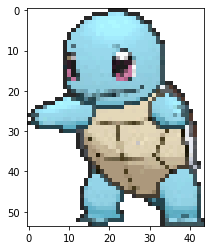

In [6]:
ch = imageio.imread('charmander-tight.png')
bb = imageio.imread('bulbasaur-tight.png')
sq = imageio.imread('squirtle-tight.png')
plt.imshow(sq)
plt.show()

In [0]:
POKE_DIM = 200
ch = np.array(ch)
bb = np.array(bb)
sq = np.array(sq)
CH_H, CH_W, CH_C = ch.shape
BB_H, BB_W, BB_C = bb.shape
SQ_H, SQ_W, SQ_C = sq.shape

# useful store these in an array
poke_data = [
  [ch, CH_H, CH_W, CH_C],
  [bb, BB_H, BB_W, BB_C],
  [sq, SQ_H, SQ_W, SQ_C],
]
class_names = ['Charmander', 'Bulbasaur', 'Squirtle']

In [0]:
def custom_loss(y_true, y_pred):
  # target is a 8-tuple
  # (row, col, depth, width, class1, class2, class3, object_appeared)

  bce = binary_crossentropy(y_true[:, :4], y_pred[:, :4]) # location
  cce = categorical_crossentropy(y_true[:, 4:7], y_pred[:, 4:7]) # object class
  bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1]) # object appeared

  return bce * y_true[:, -1] + cce * y_true[:, -1] + 0.5 * bce2

In [0]:
def make_model():
  vgg = tf.keras.applications.VGG16(
    input_shape=[POKE_DIM, POKE_DIM, 3],
    include_top=False,
    weights='imagenet')
  x = Flatten()(vgg.output)
  x1 = Dense(4, activation='sigmoid')(x) # location
  x2 = Dense(3, activation='softmax')(x) # object class
  x3 = Dense(1, activation='sigmoid')(x) # object appeared
  x = Concatenate()([x1, x2, x3])
  model = Model(vgg.input, x)
#   model.compile(loss=custom_loss, optimizer=SGD(learning_rate=0.01, momentum=0.9))
  model.compile(loss=custom_loss, optimizer=Adam(lr=0.0001))
  return model

In [11]:
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

--2020-05-23 19:55:42--  https://lazyprogrammer.me/course_files/backgrounds.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 104.31.80.48, 2606:4700:3035::681f:5130, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494000 (482K) [application/zip]
Saving to: ‘backgrounds.zip’

backgrounds.zip     100%[===================>] 482.42K   460KB/s    in 1.0s    

2020-05-23 19:55:44 (460 KB/s) - ‘backgrounds.zip’ saved [494000/494000]



In [12]:
!unzip -n backgrounds.zip

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/8.jpg       
   creating: __MACOSX/
   creating: __MACOSX/backgrounds/
  inflating: __MACOSX/backgrounds/._8.jpg  
  inflating: backgrounds/9.jpg       
  inflating: __MACOSX/backgrounds/._9.jpg  
  inflating: backgrounds/14.jpg      
  inflating: __MACOSX/backgrounds/._14.jpg  
  inflating: backgrounds/15.jpg      
  inflating: __MACOSX/backgrounds/._15.jpg  
  inflating: backgrounds/12.jpg      
  inflating: __MACOSX/backgrounds/._12.jpg  
  inflating: backgrounds/13.jpg      
  inflating: __MACOSX/backgrounds/._13.jpg  
  inflating: backgrounds/11.jpg      
  inflating: __MACOSX/backgrounds/._11.jpg  
  inflating: backgrounds/10.jpg      
  inflating: __MACOSX/backgrounds/._10.jpg  
  inflating: backgrounds/4.jpg       
  inflating: __MACOSX/backgrounds/._4.jpg  
  inflating: backgrounds/5.jpg       
  inflating: __MACOSX/backgrounds/._5.jpg  
  inflating: backgrounds/7.jpg       
  inflating: __MACOSX/back

In [0]:
from glob import glob
backgrounds = []

background_files = glob('backgrounds/*.jpg')
for f in background_files:
  # Note: they may not all be the same size
  bg = np.array(image.load_img(f))
  backgrounds.append(bg)

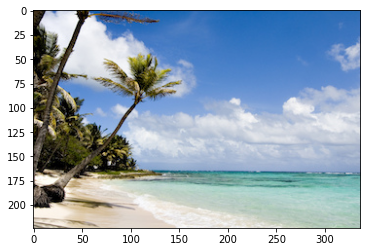

In [14]:
plt.imshow(backgrounds[3])

In [0]:
def pokemon_generator_multiclass(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 8))
      
      for i in range(batch_size):
        # select a random background
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_h = np.random.randint(bg_h - POKE_DIM)
        rnd_w = np.random.randint(bg_w - POKE_DIM)
        X[i] = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()
        
        # 25% no object, 25% + 25% + 25% for the 3 classes
        appear = (np.random.random() < 0.75)
        if appear:
          
          # choose a pokemon
          pk_idx = np.random.randint(3)
          pk, h, w, _ = poke_data[pk_idx]

          # resize object - make it bigger or smaller
          scale = 0.5 + np.random.random()
          new_height = int(h * scale)
          new_width = int(w * scale)
          obj = resize(
              pk,
              (new_height, new_width),
              preserve_range=True).astype(np.uint8) 

          # maybe flip
          if np.random.random() < 0.5:
            obj = np.fliplr(obj)

          # choose a random location to store the object
          row0 = np.random.randint(POKE_DIM - new_height)
          col0 = np.random.randint(POKE_DIM - new_width)
          row1 = row0 + new_height
          col1 = col0 + new_width

          mask = (obj[:,:,3] == 0)
          bg_slice = X[i,row0:row1,col0:col1,:] 
          bg_slice = np.expand_dims(mask, -1) * bg_slice 
          bg_slice += obj[:,:,:3] 
          X[i,row0:row1,col0:col1,:] = bg_slice
   
          # location
          Y[i,0] = row0/POKE_DIM
          Y[i,1] = col0/POKE_DIM
          Y[i,2] = (row1 - row0)/POKE_DIM
          Y[i,3] = (col1 - col0)/POKE_DIM

          # class
          Y[i,4 + pk_idx] = 1
        
        Y[i,7] = appear
      
      yield X / 255., Y

In [0]:
xx = None
yy = None
for x, y in pokemon_generator_multiclass():
  xx, yy = x, y
  break

[0.245 0.71  0.27  0.24  0.    1.    0.    1.   ]
percent no obj: 0.265625
percent charmander: 0.203125
percent bulbasaur: 0.203125
percent squirtle: 0.328125


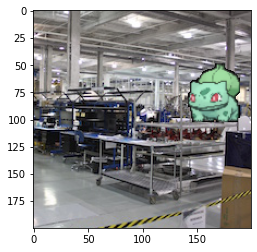

In [23]:
n = yy.shape[0]
idx = np.random.randint(n)
plt.imshow(xx[idx]);
print(yy[idx])
print("percent no obj:", (yy[:,7] == 0).sum() / n)
print("percent charmander:", yy[:,4].sum() / n)
print("percent bulbasaur:", yy[:,5].sum() / n)
print("percent squirtle:", yy[:,6].sum() / n)

In [24]:
model = make_model()
model.fit_generator(
    pokemon_generator_multiclass(),
    steps_per_epoch=50,
    epochs=5,
)

58892288/58889256 [==============================] - 1s 0us/step
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
50/50 [==============================] - 18s 355ms/step - loss: 0.6949
Epoch 2/5
50/50 [==============================] - 18s 356ms/step - loss: 0.4161
Epoch 3/5
50/50 [==============================] - 18s 356ms/step - loss: 0.4090
Epoch 4/5
50/50 [==============================] - 18s 356ms/step - loss: 0.4085
Epoch 5/5
50/50 [==============================] - 18s 355ms/step - loss: 0.4045


In [0]:
# Make predictions
def pokemon_prediction_multiclass():
  # select a random background
  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_h = np.random.randint(bg_h - POKE_DIM)
  rnd_w = np.random.randint(bg_w - POKE_DIM)
  x = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()
  
  appear = (np.random.random() < 0.75)
  if appear:

    # choose a pokemon
    pk_idx = np.random.randint(3)
    pk, h, w, _ = poke_data[pk_idx]
        
    # resize charmander - make it bigger or smaller
    scale = 0.5 + np.random.random()
    new_height = int(h * scale)
    new_width = int(w * scale)
    obj = resize(
        pk,
        (new_height, new_width),
        preserve_range=True).astype(np.uint8) # keep it from 0..255

    # maybe flip
    if np.random.random() < 0.5:
      obj = np.fliplr(obj)

    # choose a random location to store the object
    row0 = np.random.randint(POKE_DIM - new_height)
    col0 = np.random.randint(POKE_DIM - new_width)
    row1 = row0 + new_height
    col1 = col0 + new_width

 
    mask = (obj[:,:,3] == 0) 
    bg_slice = x[row0:row1,col0:col1,:]
    bg_slice = np.expand_dims(mask, -1) * bg_slice
    bg_slice += obj[:,:,:3] 
    x[row0:row1,col0:col1,:] = bg_slice 
    actual_class = class_names[pk_idx]
    print("true:", row0, col0, row1, col1, actual_class)
  
  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]
  
  # Plot
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  
  # Draw the box
  if p[-1] > 0.5:
    row0 = int(p[0]*POKE_DIM)
    col0 = int(p[1]*POKE_DIM)
    row1 = int(row0 + p[2]*POKE_DIM)
    col1 = int(col0 + p[3]*POKE_DIM)
    class_pred_idx = np.argmax(p[4:7])
    class_pred = class_names[class_pred_idx]
    print("pred:", row0, col0, row1, col1, class_pred)
    rect = Rectangle(
        (p[1]*POKE_DIM, p[0]*POKE_DIM),
        p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  else:
    print("pred: no object")
  plt.show()

true: 3 103 48 138 Charmander
pred: 5 101 44 135 Charmander


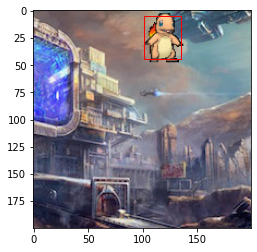

In [30]:
pokemon_prediction_multiclass()